## MCMC from file

Load hdf5 file from Data Fitting.ipynb that includes experiment meta data and time vs position data for MCMC analysis.

In [1]:
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
import scipy.io
import scipy.optimize as op
import pandas as pd
import emcee as mc
import corner

import io as IO
import pickle
import os
import os.path
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from googleapiclient.http import MediaFileUpload
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2 import service_account

In [2]:
# Shortcut functions for trigonometric functions in degrees

def sind(theta):
    """Calculate sine of theta in degrees.
    
    :Input:
     - *theta* (array_like) - Angle in degrees.
     
     :Output:
     - (array_like) - Sine value.
    
    """
    
    return np.sin(np.deg2rad(theta))

def cosd(theta):
    """Calculate cosine of theta in degrees.
    
    :Input:
     - *theta* (array_like) - Angle in degrees.
     
     :Output:
     - (array_like) - Cosine value.
    
    """
    
    return np.cos(np.deg2rad(theta))

def tand(theta):
    """Calculate cosine of theta in degrees.
    
    :Input:
     - *theta* (array_like) - Angle in degrees.
     
     :Output:
     - (array_like) - Cosine value.
    
    """
    
    return np.tan(np.deg2rad(theta))

## Flow of a Herschel-Bulkley fluid on an inclined plane following derivation from Liu & Mei (1989), Balmforth et al. (2007):

$ \frac{\partial h}{\partial t} = -\left( \frac{\rho g}{K} \right)^{1/n} \frac{\partial}{\partial x} \left[ \frac{n \left| \sin{\theta} - \cos{\theta} \frac{\partial h}{\partial x} \right|^{1/n-1} Y^{1+1/n}}{(n+1)(2n+1)} \left[(1+2n)h-nY \right] \left( \sin{\theta} -  \cos{\theta} \frac{\partial h}{\partial x} \right) \right] $

$ Y = h - \frac{\tau_y}{\rho g |\sin{\theta} -\cos{\theta} \frac{\partial h}{\partial x}|} $

For full derivation see included PDF "Viscoplastic Flow Derivation".

In [3]:
def damBreak(x, h0, theta, rho, K, tauy, n, g, ts, i):
    
    """Solve flow for a Herschel-Bulkley fluid with 2-step Runge-Kutta 
    in time, centered in space for on an inclined surface.
    
    :Input:
     - *x*     (ndarray(m+2))      - Evaluation points in x [m].
     - *h0*    (ndarray(m+2))      - Initial height at evaluation points in x [m].
     - *theta* (float)             - Slope [deg].
     - *rho*   (float)             - Fluid density [kg/m^3].
     - *K*     (float)             - Fluid consistency [Pa s].     
     - *tauy*  (float)             - Yield stress [Pa].
     - *n*     (float)             - Rheology power law exponent.
     - *g*     (float)             - Gravitational constant [m/s^2].
     - *ts*    (float)             - Final time for simulation [sec].
     - *i*     (int)               - Number of points for discretization in t.
     

    :Output:
     - (ndarray(m+2, i+2)) - Solution of ODE.
     - (ndarray(i+2)) - Evaluation times.
    """

    # Discretize domain 
    dx = x[1:] - x[:-1]
    dt = ts/(i+1)
    t = np.linspace(0, ts, i+2)

    # Initialize solution
    h = np.zeros((i+2,x.size))    
    h[0,:] = h0
    
    # Solve
    for k in np.arange(i+1):
        
        for j, s in enumerate([0.5, 1]):
            
            hr = (h[k+j,2:] + h[k+j,1:-1])/2
            hl = (h[k+j,1:-1] + h[k+j,:-2])/2
            hxr = sind(theta) - cosd(theta)*(h[k+j,2:] - h[k+j,1:-1])/dx[1:]
            hxl = sind(theta) - cosd(theta)*(h[k+j,1:-1] - h[k+j,:-2])/dx[:-1]
            Yr  = hr - tauy/(rho*g*np.abs(hxr))
            Yl  = hl - tauy/(rho*g*np.abs(hxl))
        
            Yr[Yr<0] = 0
            Yl[Yl<0] = 0
        
            Qr = n*((np.abs(hxr))**(1/n-1)*(Yr)**(1+1/n))/((n+1)*(2*n+1))*((1+2*n)*hr - n*Yr)*hxr
            Ql = n*((np.abs(hxl))**(1/n-1)*(Yl)**(1+1/n))/((n+1)*(2*n+1))*((1+2*n)*hl - n*Yl)*hxl
        
            Qr[hxr==0] = 0
            Ql[hxl==0] = 0
    
            h[k+1,1:-1] = h[k,1:-1] - s*dt/dx[:-1]*(rho*g/K)**(1/n)*(Qr - Ql)
            
            # Boundary conditions
            h[k+1,0] = h[k+1,1]
    
    return h, t

In [4]:
# import from google drive

SCOPES = ['https://www.googleapis.com/auth/drive']

"""Shows basic usage of the Drive v3 API.
Prints the names and ids of the first 10 files the user has access to.
"""
creds = None
# The file token.pickle stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists('token_JB.pickle'):
    with open('token_JB.pickle', 'rb') as token:
        creds = pickle.load(token)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            'client_secret.json', SCOPES)
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open('token_JB.pickle', 'wb') as token:
        pickle.dump(creds, token)
        
service = build('drive', 'v3', credentials=creds)

# Call the Drive v3 API
results = service.files().list(q = "name contains '55% Gas.h5'", # change just this line to the h5 filename
    pageSize=5, fields="nextPageToken, files(id, name)").execute()
items = results.get('files', [])

if not items:
    print('No files found.')

fileid = items[0]['id']
filename =  items[0]['name']
filepath = os.getcwd()
request = service.files().get_media(fileId=fileid)
fh = IO.BytesIO()
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))

print('Saving local copy')
with IO.open(filepath + '/' + filename, 'wb') as f:
    fh.seek(0)
    f.write(fh.read())
print('Done! Loaded ' + filename)

Download 100%.
Saving local copy
Done! Loaded 55% Gas.h5


      H    L    K_fluid   Rho  Slope    Title  Temp
0  0.07  0.2  12.141238  5160      0  55% Gas  18.8
   X_pos      Time
0    0.0  0.033367
1    0.0  0.066733
2    0.0  0.100100
3    0.0  0.133467
4    0.0  0.166833


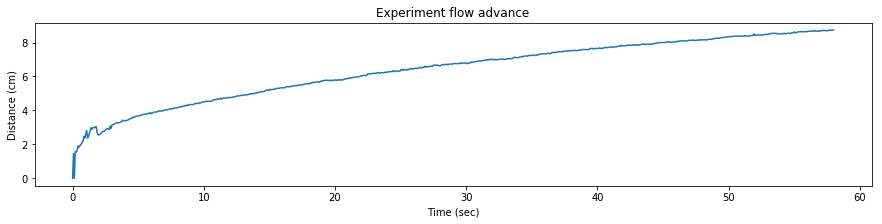

In [5]:
meta = pd.read_hdf(filename, key='meta')
print(meta)
H = meta.H[0]
L = meta.L[0]
K_fluid = meta.K_fluid[0]
rho = meta.Rho[0]
theta = meta.Slope[0]
T = meta.Temp[0]

dat = pd.read_hdf(filename, key='df')
print(dat.head())

t0 = 1 # Time of dam release [sec]
tloc = int(t0/(dat.Time[1] - dat.Time[0]))
t_pos = dat.Time.iloc[tloc:] - dat.Time.iloc[tloc]
t_pos = t_pos*2
x_pos = dat.X_pos.iloc[tloc:]- dat.X_pos.iloc[tloc]

# plot scaled front advance
fig,ax = plt.subplots(figsize=(15,3))
ax.plot(t_pos, x_pos*100)
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Distance (cm)')
ax.set_title('Experiment flow advance');

In [12]:
# Setup model for MCMC

def lnlike(mu, x, y, yerr):
    K, tauy, n = mu
    h, t = damBreak(x_grid, h0, 0, 1540, K, tauy, n, 9.81, t_pos.iloc[-1], 25*t_pos.size)
    X = np.zeros_like(t_pos)

    threshold = 0.0001
    for j in np.arange(t_pos.shape[0]):
        X[j] = x_grid[np.max(np.nonzero(h[j*25,:]>threshold)) + 1] # find node with h>threshold

    model = X
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*yerr**2)))

In [17]:
x_grid
h0

array([0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [11]:
# Initial guesses for MCMC
K_init = 6
K_min = 3
K_max = 10

tauy_init = 0.05
tauy_min = 0
tauy_max = 0.5

n_init = 1
n_min = 0.8
n_max = 3

init_pos = [K_init, tauy_init, n_init]

# load data to MCMC
x = t_pos
y = x_pos + L

# Define model resolution for MCMC
x_grid = np.linspace(0,0.75,22)
dx = x_grid[1] - x_grid[0]
yerr = dx
h0 = np.zeros_like(x_grid)
h0[x_grid<0.2] = H

In [13]:
# Uniform prior distribution
def lnprior(mu):
    K, tauy, n = mu
    if K_min < K < K_max and tauy_min < tauy < tauy_max and n_min < n < n_max:
        return 0.0
    return -np.inf

def lnprob(mu, x, y, yerr):
    lp = lnprior(mu)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(mu, x, y, yerr)# Create walkers

In [33]:
# Create walkers
ndim, nwalkers = 3, 6
mu_pos = [init_pos + [1e-2, 1e-2, 1e-2]*np.random.randn(ndim) for i in range(nwalkers)]

[array([6.00554386, 0.04630485, 0.99971183]),
 array([5.99840539, 0.07204115, 0.97988358]),
 array([5.99922881, 0.04485309, 0.99772731]),
 array([5.99670294, 0.04806411, 1.00678611]),
 array([5.99477609, 0.06660398, 1.00352866]),
 array([6.00874359, 0.05665768, 0.99032075])]

In [ ]:
# Run MCMC
sampler = mc.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(mu_pos, 30);

C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in power
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in power
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply


In [ ]:
# Inspect MCMC results
s = 0 # ignore initial samples
samples = sampler.chain[:, s:, :].reshape((-1, ndim))

K_fit = samples[:,0]; tauy_fit = samples[:,1]; n_fit = samples[:,2]

# Find mode of each posterior distribution
N, bin_edges = np.histogram(K_fit, bins=20)
K_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
N, bin_edges = np.histogram(tauy_fit, bins=20)
tauy_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
N, bin_edges = np.histogram(n_fit, bins=20)
n_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 

# plot
fig = corner.corner(samples, labels=["K", "tauy", "n"],
                   truths=[K_post, tauy_post, n_post])
print('K = ' + np.array2string(K_post, precision=1) + 
      ', tau_y = ' + np.array2string(tauy_post, precision=2) + 
      ', n = ' + np.array2string(n_post, precision=2))

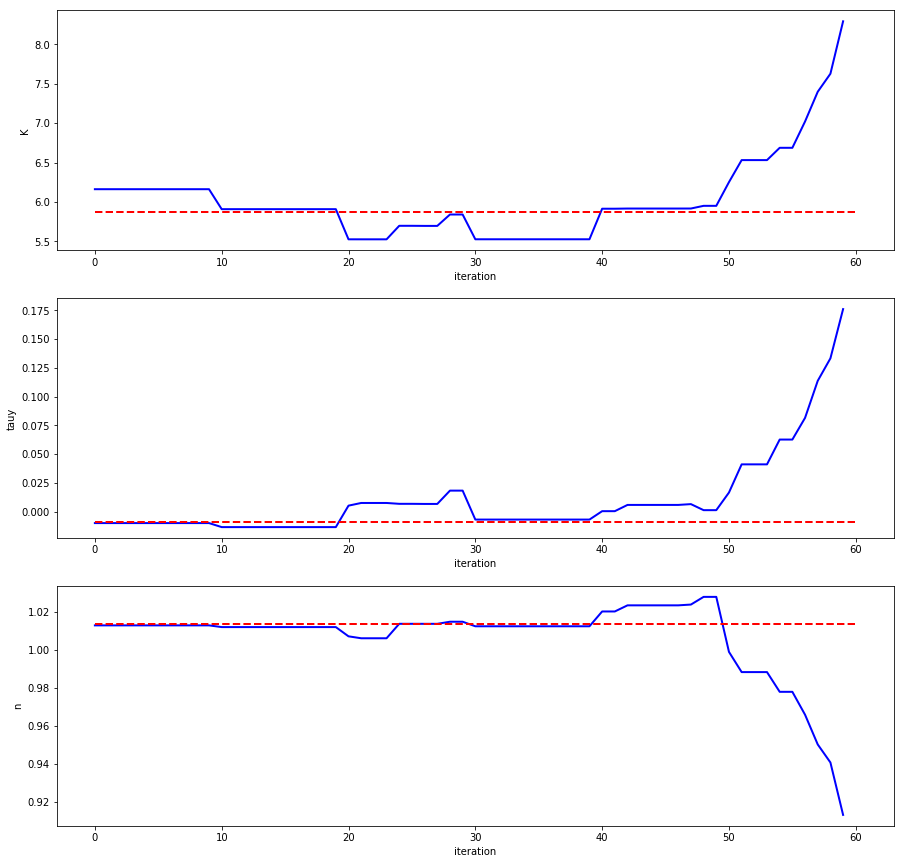

In [124]:
# inspect runs
samples_full = sampler.chain[:, :, :].reshape((-1, ndim))

fig,ax = plt.subplots(nrows=3, figsize=(15,15))
ax[0].plot(samples_full[:,0],'b-')
ax[0].plot([0, samples_full.shape[0]],[K_post, K_post],'r--')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('K')
ax[1].plot(samples_full[:,1],'b-')
ax[1].plot([0, samples_full.shape[0]],[tauy_post, tauy_post],'r--')
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('tauy')
ax[2].plot(samples_full[:,2],'b-')
ax[2].plot([0, samples_full.shape[0]],[n_post, n_post],'r--')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('n');

In [126]:
# Plot most probable model with data

h, t = damBreak(x_grid, h0, 0, 1540, K_post, tauy_post, n_post, 9.81, t_pos.iloc[-1], 25*t_pos.size)
X = np.zeros_like(t_pos)
t_match = np.zeros_like(t_pos)

threshold = 0.0001
for j in np.arange(t_pos.size):
    X[j] = x_grid[np.max(np.nonzero(h[j*25,:]>threshold)) + 1] # find node with h>threshold
    t_match[j] = t[j*25]

# Plot front advance
fig,ax = plt.subplots(figsize=(20,10))

ax.plot(t_match,X,'r-',label='model');
ax.plot(t_pos,x_pos+L,label='experiment')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance (m)')
ax.set_title('Model fit to experiment')
ax.legend();

C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in power
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in power
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: overflow enc

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
# Save posterior distribution

meta['K_post'] = K_post
meta['K_r'] = K_post/K_fluid
meta['tauy_post'] = tauy_post
meta['n_post'] = n_post

meta.to_hdf(title_str + '.h5', key='meta', mode='a')

samples = pd.DataFrame({'K':K_fit, 'tauy':tauy_fit, 'n':n_fit})
samples.to_hdf(title_str + '.h5', key='s', mode='a')

file_metadata = {'name': title_str + '.h5', 'parents': ['1zM6oSJugXEWYybwzwO0YVvfAShTHpKbp']}
media = MediaFileUpload(title_str + '.h5')
file = service.files().create(body=file_metadata,
                                    media_body=media).execute()

In [ ]:
# remove local files after upload
media = None
os.remove(filename)